In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
!pip install transformers
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

2.11.0
4.27.4


# 📋 Loading the Data

In [2]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")
#df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')
#df = pd.read_csv('/kaggle/input/extended-covid-twitter-datasets/sample_data_global.csv')
df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Reddit_Data.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Twitter_Data.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB
None


In [4]:
df = df.dropna()
df

clean_comment  category
0       family mormon have never tried explain them t...         1
1      buddhism has very much lot compatible with chr...         1
2      seriously don say thing first all they won get...        -1
3      what you have learned yours and only yours wha...         0
4      for your own benefit you may want read living ...         1
...                                                  ...       ...
37244                                              jesus         0
37245  kya bhai pure saal chutiya banaya modi aur jab...         1
37246              downvote karna tha par upvote hogaya          0
37247                                         haha nice          1
37248             facebook itself now working bjp’ cell          0

[37149 rows x 2 columns]

In [5]:
# df['text'] = df['clean_tweet']
# df['target'] = df['senti_textblob']
df['text'] = df['clean_comment']
df['target'] = df['category']

In [6]:
'''
import pandas as pd

# assuming your dataframe is named 'df'
num_samples_per_label = 2000

# group the dataframe by the label column
grouped_df = df.groupby('target')

# sample a specified number of rows from each group
sampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))

# reset the index of the resulting dataframe
sampled_df = sampled_df.reset_index(drop=True)
df = sampled_df 
'''

"\nimport pandas as pd\n\n# assuming your dataframe is named 'df'\nnum_samples_per_label = 2000\n\n# group the dataframe by the label column\ngrouped_df = df.groupby('target')\n\n# sample a specified number of rows from each group\nsampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))\n\n# reset the index of the resulting dataframe\nsampled_df = sampled_df.reset_index(drop=True)\ndf = sampled_df \n"

In [7]:
df = df.drop(columns = ['clean_comment','category'])
df

text  target
0       family mormon have never tried explain them t...       1
1      buddhism has very much lot compatible with chr...       1
2      seriously don say thing first all they won get...      -1
3      what you have learned yours and only yours wha...       0
4      for your own benefit you may want read living ...       1
...                                                  ...     ...
37244                                              jesus       0
37245  kya bhai pure saal chutiya banaya modi aur jab...       1
37246              downvote karna tha par upvote hogaya        0
37247                                         haha nice        1
37248             facebook itself now working bjp’ cell        0

[37149 rows x 2 columns]

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [9]:
train

text  target
31732  oooooooooooh remember this chutiya was the one...       1
34911                     one that good hijacking media        1
738                      harshvardhan ahead 43350 votes        0
11430  epaper here anyone wants the free encyclopedia...       1
17796                          fuck boys heart pounding       -1
...                                                  ...     ...
16887   curious don have much knowledge law but don h...       1
6276                             will shittier than any        0
11309  jokes pretty common name amongst the car drive...      -1
862         because arvind kejriwal reminds robespierre        0
15830  good lord the quint website cancer and incompl...       1

[29719 rows x 2 columns]

In [10]:
print("train, counts of label '1': {}".format(sum(train.target == 1)))
print("train, counts of label '0': {}".format(sum(train.target == 0)))
print("train, counts of label '-1': {}\n".format(sum(train.target == -1)))
print("test, counts of label '1': {}".format(sum(test.target == 1)))
print("test, counts of label '0': {}".format(sum(test.target == 0)))
print("test, counts of label '-1': {}".format(sum(test.target == -1)))

train, counts of label '1': 12651
train, counts of label '0': 10388
train, counts of label '-1': 6680

test, counts of label '1': 3179
test, counts of label '0': 2654
test, counts of label '-1': 1597


In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#train = reduce_mem_usage(train)
#train = reduce_mem_usage(test)

In [12]:
#train2, test2 = train, test

# 🔨 Preprocessing

In [13]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [14]:
seq_len = 256 #max([len(text) for text in train['text']]) #256
batch_size = 16 #16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [15]:
size

1299

In [16]:
labels.shape

(29719, 3)

# 🤖 Model Building

In [18]:
####### MODEL 3 #########
'''
In this example, a BiLSTM layer is added after the Transformer layer. The number of units in the BiLSTM layer is set to 64, 
but you can modify this value based on your specific use case. The output of the BiLSTM layer is passed through two dense layers, 
each with 512 units and a ReLU activation function, before being fed to the classifier head.
'''
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add a BiLSTM layer
lstm_units = 512 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)
attention_layer = tf.keras.layers.Attention()([lstm, lstm])

# Add Dense layers
#x = tf.keras.layers.Dense(512, activation='relu')(lstm)
x = tf.keras.layers.Dense(512, activation='relu')(attention_layer)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# Flatten the output tensor
x = tf.keras.layers.Flatten()(x)

# Classifier head
outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

# Create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

'''
In the above example, monitor specifies the metric to be monitored for early stopping, 
patience specifies the number of epochs with no improvement after which training will be stopped, 
mode specifies whether the monitored metric should be minimized or maximized, and 
restore_best_weights specifies whether to restore the weights of the model corresponding to the epoch with the best monitored metric value.

Adagrad
Adadelta
RMSprop

1.2277e-05 (best val loss)


import math
# Define the LearningRateScheduler callback
initial_learning_rate = 1e-3
def lr_exp_decay(epoch):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

'''

filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 20,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] #
)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20
1299/1299 [==============================] - ETA: 0s - loss: 0.4317 - categorical_accuracy: 0.8397
Epoch 1: loss improved from inf to 0.43174, saving model to model.h5
1299/1299 [==============================] - 1336s 995ms/step - loss: 0.4317 - categorical_accuracy: 0.8397 - val_loss: 0.2428 - val_categorical_accuracy: 0.9167
Epoch 2/20
1299/1299 [==============================] - ETA: 0s - loss: 0.2292 - categorical_accuracy: 0.9238
Epoch 2: loss improved from 0.43174 to 0.22917, saving model to model.h5
1299/1299 [==============================] - 1286s 990ms/step - loss: 0.2292 - categorical_accuracy: 0.9238 - val_loss: 0.1653 - val_categorical_accuracy: 0.9470
Epoch 3/20
1299/1299 [==============================] - ETA: 0s - loss: 0.1680 - categorical_accuracy: 0.9459
Epoch 3: loss improved from 0.22917 to 0.16801, saving model to model.h5
1299/1299 [==============================] - 1279s 985ms/step - loss: 0.1680 - categorical_accuracy: 0.9459 - val_loss: 0.1558 - va

KeyboardInterrupt: 

In [34]:
model.load_weights('/kaggle/working/model.h5')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 1,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] #
)

1299/1299 [==============================] - ETA: 0s - loss: 0.0364 - categorical_accuracy: 0.9896
Epoch 1: loss improved from inf to 0.03637, saving model to model.h5
1299/1299 [==============================] - 1284s 981ms/step - loss: 0.0364 - categorical_accuracy: 0.9896 - val_loss: 0.0432 - val_categorical_accuracy: 0.9880


In [50]:
!zip -r file.zip /kaggle/working/model.h5

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/model.h5 (deflated 19%)


In [ ]:
'''
###### MODEL 1 ####

model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
# embeddings = model.bert(input_ids, attention_mask=mask)[1]
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = embeddings[:, 0, :]
#embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
#x = tf.keras.layers.Dropout(0.1)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layers
# bert_model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)
'''

In [ ]:
'''

### MODEL 2 ####
model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
#embeddings = embeddings[:, 0, :]

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)


bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate= 4e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)
'''

# LIME Explainer

In [62]:
# 0 -> Neg, 1 -> Neu, 2 -> Pos
test3 = test[test['target']==0]

In [63]:
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])

0 you killed karma
1 modi undoubtedly the worst thing that has happened india will anything including announcing emergency and enforcing dictatorship power this seem the end game
2 don care about his personal life but brought this upon himself was not right him deny her existence previous elections and now finally admit before this one the one who publicly claimed has one corrupt for reading indian express article about his wife she came off someone who still admires and respects modi and wished nothing but success for him taking that into consideration its begs the question how modi views women general
3 don worry guys cows will give high quality oxygen fuck these dump ass trees
4 now this guy modi corner before they struck deal they were criticizing modi everyday bloody hypocrites
5 but but will bring back all the black money that every indian will get 15 lakhs into their bank account
6 conservative indian here live the usa right now any case want you all know that this maliciously w

In [64]:
idx = 13

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

for ind, (i, row) in enumerate(test3.iterrows()):
    if ind == idx:
        print(row.text)
        tokens = prep_data(row['text'])

# We choose a sample from test set

test_text = np.array(test3['text'])
test_class = np.array(test3['target'])
text_sample = test_text[idx]
class_names = ['Negative','Neutral','Positive']
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])

bit out the loop sorry but what does chowkidar mean
1/1 [==============================] - 0s 78ms/step
Probability = [[1. 0. 0.]]
True class: Negative


In [65]:
def predict_fn(x):    
    x =  prep_data(x)
    return model.predict(x)

print(text_sample)
print('Probability =', model.predict(tokens).round(3))
print('True class: %s' % class_names[test_class[idx]])

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text_sample, predict_fn, num_features=12, top_labels=3)
exp.show_in_notebook(text=text_sample)

bit out the loop sorry but what does chowkidar mean
1/1 [==============================] - 0s 75ms/step
Probability = [[1. 0. 0.]]
True class: Negative
157/157 [==============================] - 81s 514ms/step


# SHAP Explainer

In [51]:
test3 = test[test['target']==2]
for ind, (i, row) in enumerate(test3.iterrows()):
    print(ind, row['text'])

0 was voluntary sale not forced anyone then what the problem
1 weird see this because was just talking about our shitty insurance the said that countries like india will probably get better insurance program before get something like medicaid for all then read this know not everyone that covered but great start happy that people that can afford insurance will able get treatment
2 from his interview with the pakistan news channel judge for yourselves asked pakistan remove modi anchor moeed pirzada what are the three priorities you think should done right now resolve indo pak crisis mani shankar aiyar first you need remove modi otherwise the talks will not move forward moeed pirzada but whom are you saying this are you saying this isi remove modi mani shankar aiyar have wait for four years for this these people are very optimistic about modi they think that talks will move forward with modi presence but don think
3 not emotional person but this makes almost tear and have idea why think h

In [52]:
#test3[21:29] negative
#test3[47:54] neutral
test3[19:26] # positive

text  target  prediction
17802         now manage lose respectable manner content       2           2
2325            this guy becoming more and more like mao       2           2
18276  ius soli una favoletta buona per gli allocchi ...       2           2
18410  don understand why people are underrating clut...       2           2
2746   because respect women just much love jihadists...       2           2
11808  indian here providing another comparison for t...       2           2
898    arvind kejriwal thousand times better than con...       2           2

In [53]:
import shap 
import scipy.special

def predictor(x):
    input_ids = tokenizer(x, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')['input_ids']
    attention_mask = tokenizer(x, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')['attention_mask']
    outputs = model.predict([input_ids, attention_mask])
    probas = tf.nn.softmax(outputs).numpy()
    val = scipy.special.logit(probas[:,1])
    return val

def f_batch(x):
    val = np.array([])
    for i in x:
        val = np.append(val, predictor(i))
    return val

explainer_roberta = shap.Explainer(f_batch, tokenizer)

shap_values = explainer_roberta(test3['text'][19:26].tolist())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
1/1 [=======================

Partition explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


  0%|          | 0/110 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step


Partition explainer:  43%|████▎     | 3/7 [00:26<00:22,  5.70s/it]

1/1 [==============================] - 0s 75ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 69ms/step


Partition explainer:  57%|█████▋    | 4/7 [01:29<01:28, 29.56s/it]

1/1 [==============================] - 0s 73ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step


Partition explainer:  71%|███████▏  | 5/7 [02:32<01:24, 42.17s/it]

1/1 [==============================] - 0s 77ms/step


  0%|          | 0/132 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step


Partition explainer:  86%|████████▌ | 6/7 [02:45<00:32, 32.09s/it]

1/1 [==============================] - 0s 75ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step


Partition explainer: 100%|██████████| 7/7 [03:48<00:00, 42.18s/it]

1/1 [==============================] - 0s 77ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


Partition explainer: 8it [04:49, 41.41s/it]                       


In [54]:
shap.plots.text(shap_values)

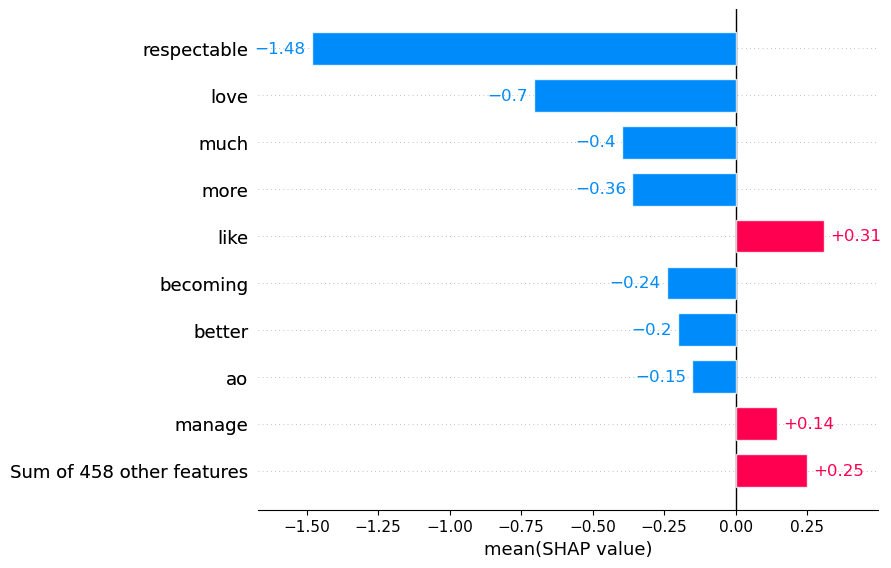

In [55]:
%matplotlib inline
shap.plots.bar(shap_values.mean(0))
plt.show()

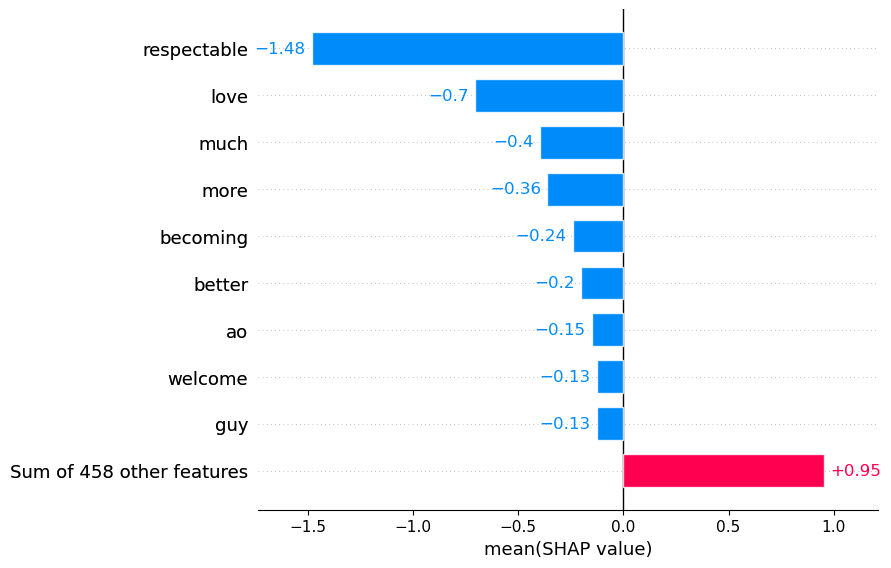

In [56]:
# we can sort the bar chart in decending order
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort)

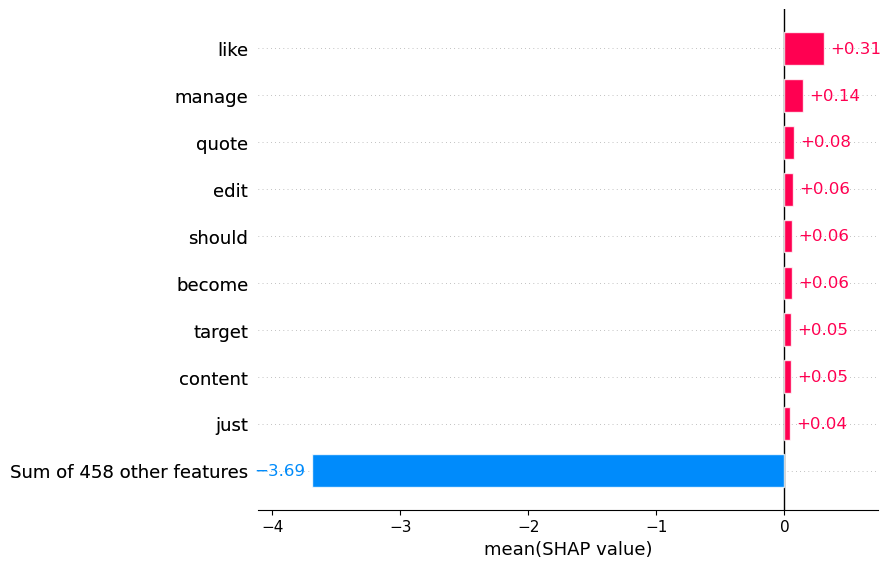

In [57]:
# ...or acending order
shap.plots.bar(shap_values.mean(0), order=shap.Explanation.argsort.flip)

# Model Architecture

In [ ]:
'''
import matplotlib.pyplot as plt

# Plot the learning rate schedule
plt.figure(figsize=(8, 6))
lrs = [lr_exp_decay(epoch) for epoch in range(50)]
plt.plot(lrs, '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.title('Learning Rate vs Epoch')
plt.xlabel('Epoch')  ## Epoch vs Learning rate
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('lr_vs_epoch.png')

# Plot the loss versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['val_loss'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss vs Learning Rate')
plt.savefig('val_loss_vs_lr.png')

# Plot the loss versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['loss'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss vs Learning Rate')
plt.savefig('train_loss_vs_lr.png')

# Plot the accuracy versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['categorical_accuracy'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Training Accuracy')
plt.legend()
plt.title('Training Accuracy vs Learning Rate')
plt.savefig('train_acc_vs_lr.png')

# Plot the accuracy versus learning rate
plt.figure(figsize=(8, 6))
plt.plot(lrs, history.history['val_categorical_accuracy'], '-o', label='Exponential decay\n1e-3 * e^(-0.1*epoch)')
plt.xscale('log')
plt.xlabel('Learning Rate (log)')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy vs Learning Rate')
plt.savefig('val_acc_vs_lr.png')
'''

In [ ]:
'''
# Find the best learning rate based on the validation loss
val_losses = history.history['val_loss']
best_lr_idx = val_losses.index(min(val_losses))
best_lr = lr_exp_decay(best_lr_idx)
print('Best Learning Rate:', best_lr)
'''

In [35]:
bert_model = model

In [36]:
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


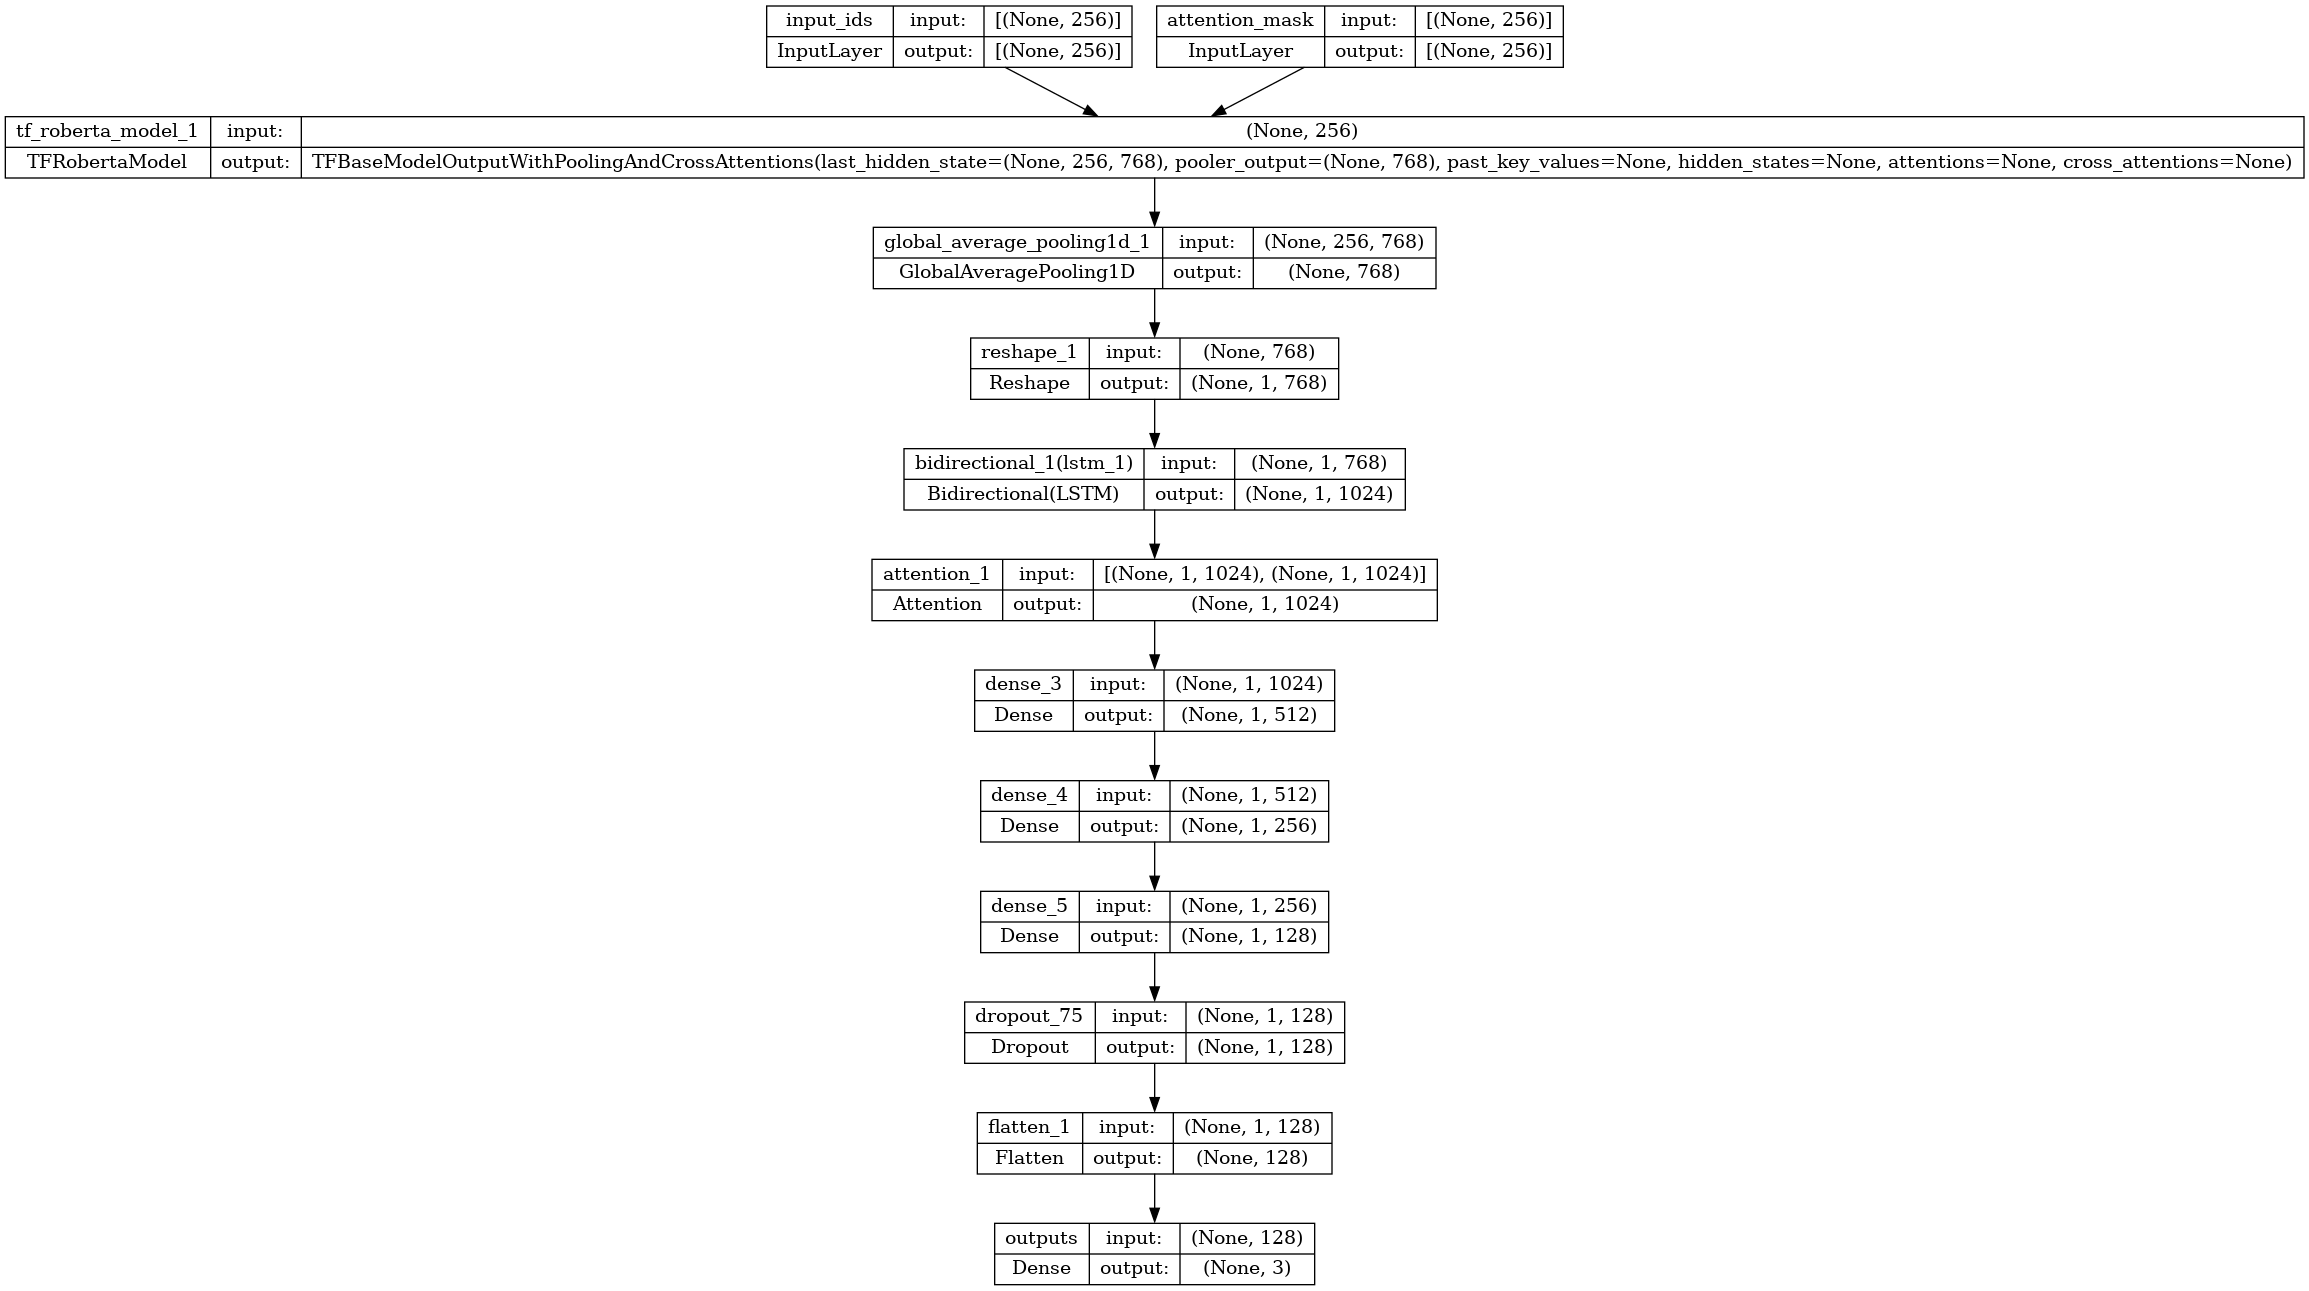

In [37]:
tf.keras.utils.plot_model(bert_model, to_file = 'bert_model1.png', show_shapes=True, show_layer_names = True)

# 📊 Model Evaluation

In [38]:
# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import wordcloud

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

In [39]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss1.png')
    
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(r.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy1.png')

In [49]:
#plot_learning_evolution(history)

In [41]:
bert_model.evaluate(val_ds)

558/558 [==============================] - 152s 272ms/step - loss: 0.0405 - categorical_accuracy: 0.9881


[0.04053967446088791, 0.9881272315979004]

In [42]:
bert_model.evaluate(train_ds)

1299/1299 [==============================] - 353s 271ms/step - loss: 0.0270 - categorical_accuracy: 0.9923


[0.02700463868677616, 0.9923017621040344]

In [43]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)
test

text  target  prediction
70     after seeing this uvjx 3 kwoehw video seems an...       1           1
12530                                   you killed karma       0           0
35674  was voluntary sale not forced anyone then what...       2           2
24178  weird see this because was just talking about ...       2           2
25098  modi undoubtedly the worst thing that has happ...       0           0
...                                                  ...     ...         ...
20874  aise news sunn kar lagta hai manavta khatam ch...       1           1
32589  are you modi fan assume after seeing several y...       1           1
22632  don let this wannabe dictator promises fool yo...       1           1
20058             amit shah gave lying for the holy week       1           1
1930   did the whitecaps goalie run the wrong goal th...       0           0

[7430 rows x 3 columns]

In [44]:
labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1597
     Neutral       0.98      0.96      0.97      2654
    Positive       0.94      0.93      0.94      3179

    accuracy                           0.94      7430
   macro avg       0.93      0.93      0.93      7430
weighted avg       0.94      0.94      0.94      7430



In [45]:
test.head()

text  target  prediction
70     after seeing this uvjx 3 kwoehw video seems an...       1           1
12530                                   you killed karma       0           0
35674  was voluntary sale not forced anyone then what...       2           2
24178  weird see this because was just talking about ...       2           2
25098  modi undoubtedly the worst thing that has happ...       0           0

In [46]:
test.target.value_counts()

2    3179
1    2654
0    1597
Name: target, dtype: int64

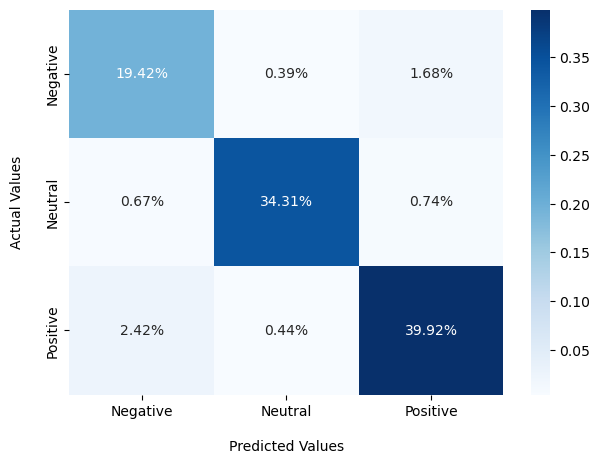

In [47]:
from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

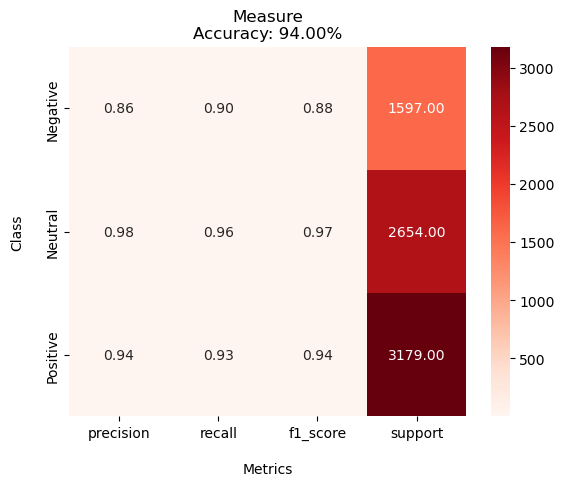

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()
